## 1) PACKAGES AND LIBRARIES INSTALLATION 
(TO DO: explain why we need each package)

In [18]:
!pip install 'plotnine[all]'
!pip install spacy
!python -m spacy download en
!pip install -U textblob
!python -m textblob.download_corpora

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/Sarah/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/Sarah/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
Requirement already up-to-date: textblob in /Users/Sarah/anaconda3/lib/python3.7/site-packages (0.15.3)
[nltk_data] Downloading package brown to /Users/Sarah/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Sarah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Sarah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Sarah/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll200

In [19]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spacy.lang.en import English
from textblob import TextBlob

## 2) DATABASE
`tweets` is our **main dataset**, the other ones are not used by the moment.

In [20]:
# The dataset from Kaggle:
tweets = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/Tweets.csv")
AAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/AAL.csv")
DAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/DAL.csv")
LUV = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/LUV.csv")
UAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/UAL.csv")

In [22]:
# Dataframe tweets shape
print(tweets.shape)

# Data types
print(tweets.dtypes)

(14640, 15)
tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


## 3) DATA CLEANING
*May be we can include here the data cleaning from Machine Learning section*

In [23]:
# Drop the columns we don't use
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'user_timezone'])

# Statistical summary of the DataFrame, with quartiles, median, etc.
print(tweets[['airline_sentiment_confidence', 'negativereason_confidence']].describe())

       airline_sentiment_confidence  negativereason_confidence
count                  14640.000000               10522.000000
mean                       0.900169                   0.638298
std                        0.162830                   0.330440
min                        0.335000                   0.000000
25%                        0.692300                   0.360600
50%                        1.000000                   0.670600
75%                        1.000000                   1.000000
max                        1.000000                   1.000000


## 4) EXPLORATORY DATA ANALYSIS

### 4.1) Sentiment Analysis by Airline
We want to visualize the **distribution sentiment analysis by company**.


The most common class is negative mood = 62.69%


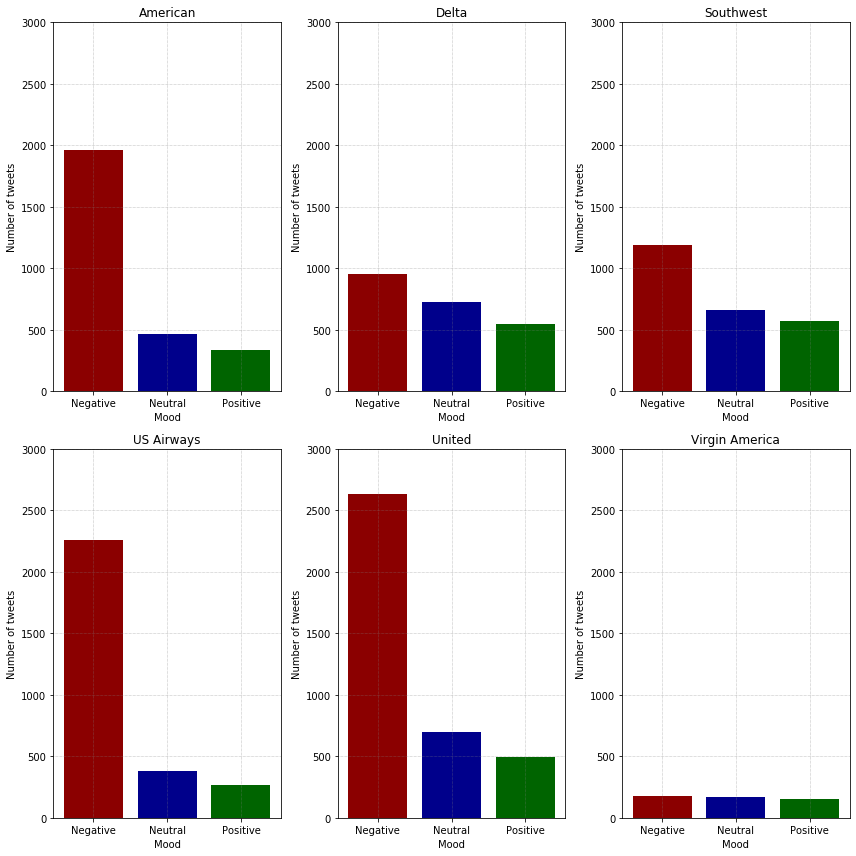

In [24]:
def sentiment_by_airline(Airline):
  df=tweets[tweets['airline']==Airline]
  count=df['airline_sentiment'].value_counts()
  Index = [1,2,3]
  plt.bar(Index,count,color=['darkred', 'darkblue', 'darkgreen'])
  plt.xticks(Index,['Negative','Neutral','Positive'])
  plt.ylabel('Number of tweets')
  plt.xlabel('Mood')
  plt.title(Airline)
  plt.ylim(0,3000)
  plt.grid(which='major', linestyle=':', linewidth='0.5', color='grey')

airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))


for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  sentiment_by_airline(airline)
plt.tight_layout()

count=tweets['airline_sentiment'].value_counts()
print("The most common class is negative mood = "+"{:.2%}".format(count[0]/sum(count[0:3])))


### 4.2) Negative Reason by Airline
In the previous graph we saw that the most common class was the *Negative mood*. Now we want to visualize the **negative ratings clustered on topics**.

The 3 main negative topics of American are: (1) Customer Service Issue, (2) Late Flight and (3) Cancelled Flight
The 3 main negative topics of Delta are: (1) Late Flight, (2) Customer Service Issue and (3) Can't Tell
The 3 main negative topics of Southwest are: (1) Customer Service Issue, (2) Cancelled Flight and (3) Can't Tell
The 3 main negative topics of US Airways are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of United are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of Virgin America are: (1) Customer Service Issue, (2) Flight Booking Problems and (3) Can't Tell


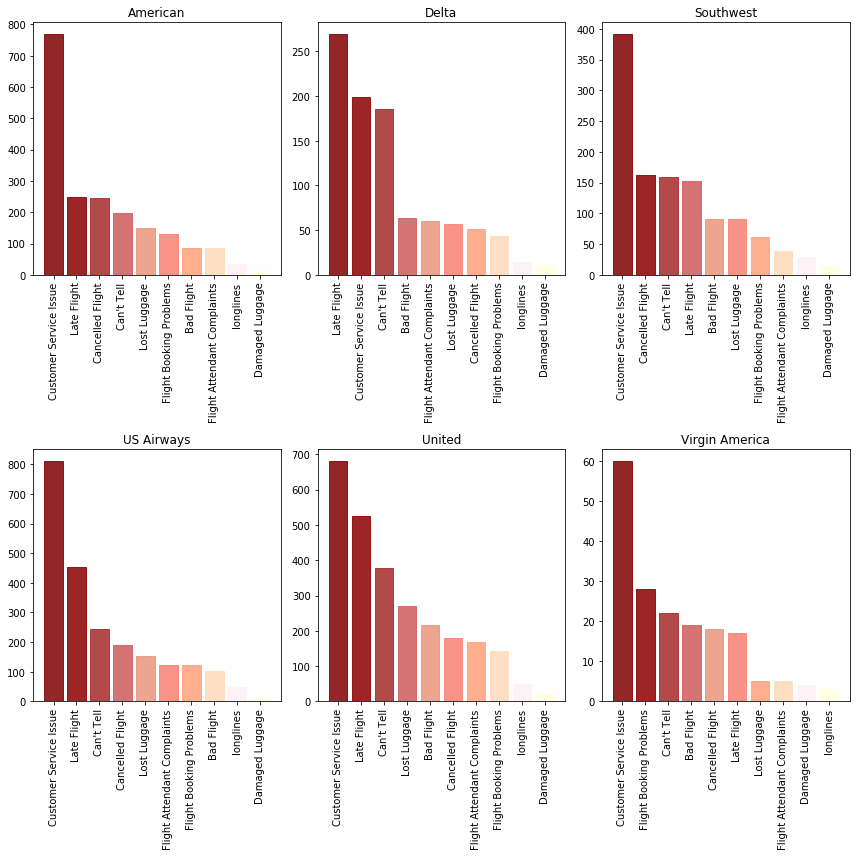

In [25]:
cmap = ['maroon', 'darkred', 'brown', 'indianred', 'darksalmon', 'salmon', 'lightsalmon', 'peachpuff', 'lavenderblush', 'lightyellow']
def negative_reason(Airline):
  df=tweets[tweets['airline']== Airline]
  Neg_reasons_values = df['negativereason'].value_counts(sort=True)
  Neg_reasons_labels = dict(df['negativereason'].value_counts(sort=True))
  Index = range(len(Neg_reasons_values))
  barplot = plt.bar(Index,Neg_reasons_values, alpha = 0.85)
  
  plt.xticks(Index,Neg_reasons_labels, rotation = 90)
  plt.title(Airline)

  for color in cmap:
    barplot[cmap.index(color)].set_color(color)
  
  return ("The 3 main negative topics of " + Airline + " are: (1) " + list(Neg_reasons_labels.keys())[0] + 
  ", (2) " + list(Neg_reasons_labels.keys())[1] + " and (3) " + list(Neg_reasons_labels.keys())[2])


airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))

for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  print(negative_reason(airline))

plt.tight_layout()



### 4.3) Tweet volum per day


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

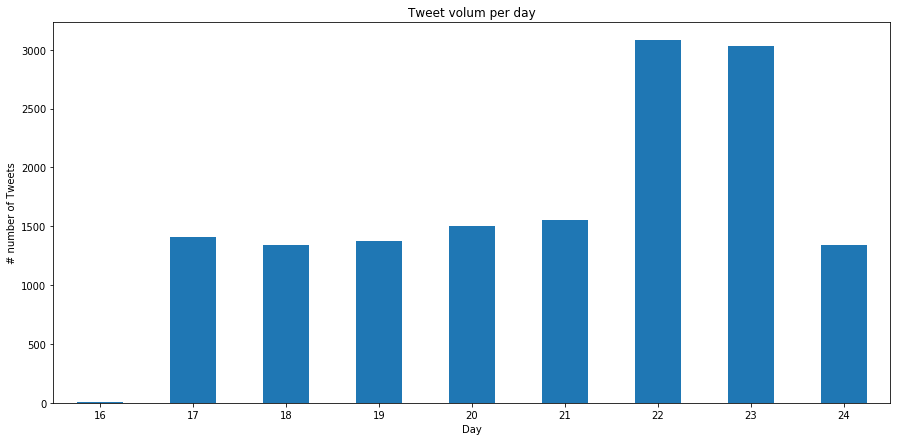

In [26]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
X = df['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day]).count().plot(kind="bar")
ax.set_title('Tweet volum per day')
ax.set_ylabel("# number of Tweets")
ax.set_xlabel("Day")
plt.xticks(rotation = 0)


### 4.4) Tweet volum per hour and per day


/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, '# number of Tweets')

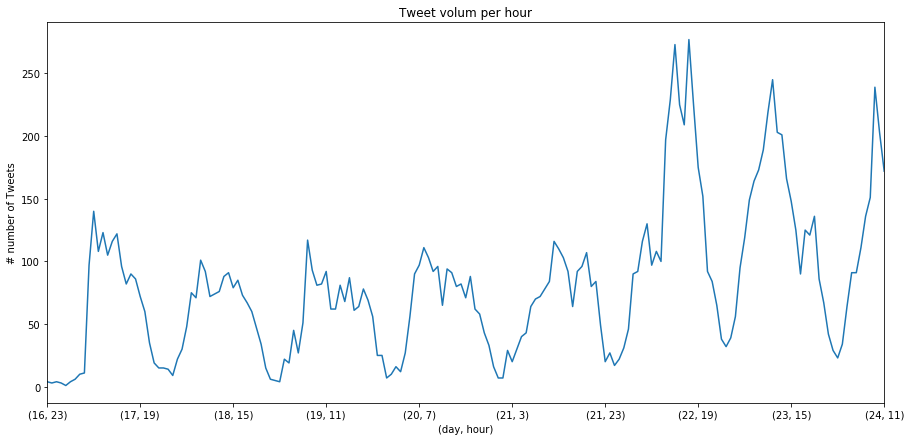

In [27]:
df = tweets[['tweet_created', 'airline_sentiment_confidence']]
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
X = df['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day,X.dt.hour]).count().plot(ax=ax)
ax.set_title('Tweet volum per hour')
ax.set_xlabel("(day, hour)")
ax.set_ylabel("# number of Tweets")


### 4.5) Stock market
*NOT IMPLEMENTED YET*

In [28]:
# Preparing the dataset
"""X_AAL = pd.to_datetime(AAL["Date"])
y_AAL = (AAL["Low"] + AAL["High"])/2
X_DAL = DAL["Date"]
y_DAL = (DAL["Low"] + DAL["High"])/2

# Initialize the data
data = pd.DataFrame(data={'Date': X_AAL, 'Avg Price': y_AAL})

# Create an lineplot
plt.figure(figsize=(15,7))
sns.lineplot(x="Date", y="Avg Price", data=data)
plt.title("American Airlines (AAL)")
plt.show()"""

'X_AAL = pd.to_datetime(AAL["Date"])\ny_AAL = (AAL["Low"] + AAL["High"])/2\nX_DAL = DAL["Date"]\ny_DAL = (DAL["Low"] + DAL["High"])/2\n\n# Initialize the data\ndata = pd.DataFrame(data={\'Date\': X_AAL, \'Avg Price\': y_AAL})\n\n# Create an lineplot\nplt.figure(figsize=(15,7))\nsns.lineplot(x="Date", y="Avg Price", data=data)\nplt.title("American Airlines (AAL)")\nplt.show()'

### 4.6) World cloud

In [30]:
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

     |████████████████████████████████| 163kB 272kB/s eta 0:00:01


#### 4.6.1) Draw wordcloud function

The function **`draw_wordcloud`** allows the user to *show* the drawcloud according the sentiment:

**Arguments**: 
*   `sentiment`: string string representing the sentiment(positive, negative, neutral). 

In [31]:
def draw_wordcloud(sentiment):
    sentiment_tweets  =tweets[tweets['airline_sentiment']== sentiment]
    words = ' '.join(sentiment_tweets['text'])
    cleaned_word = " ".join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000, height=2500).generate(cleaned_word)
    plt.figure(1,figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

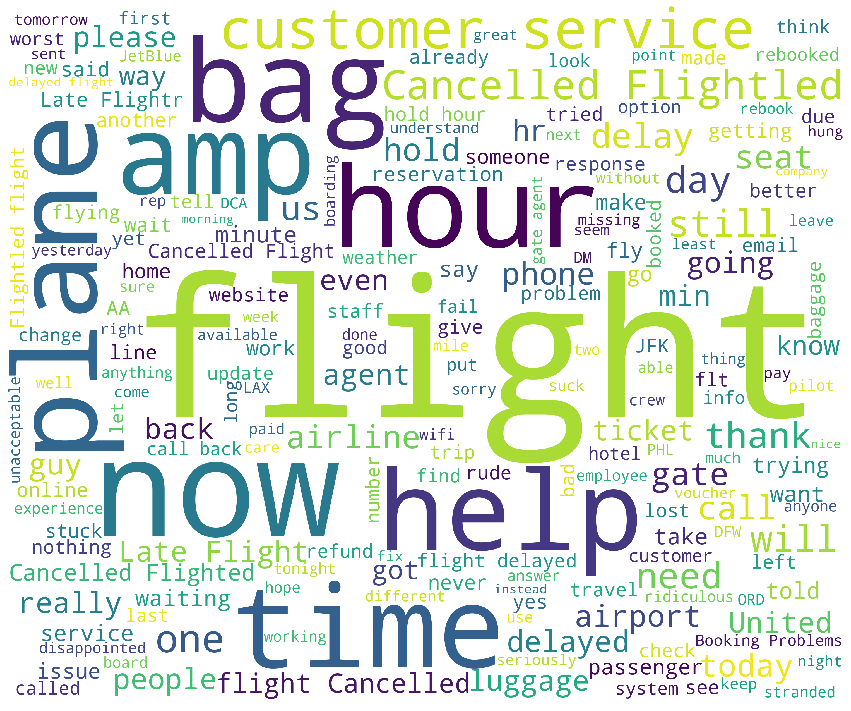

In [32]:
draw_wordcloud('negative')

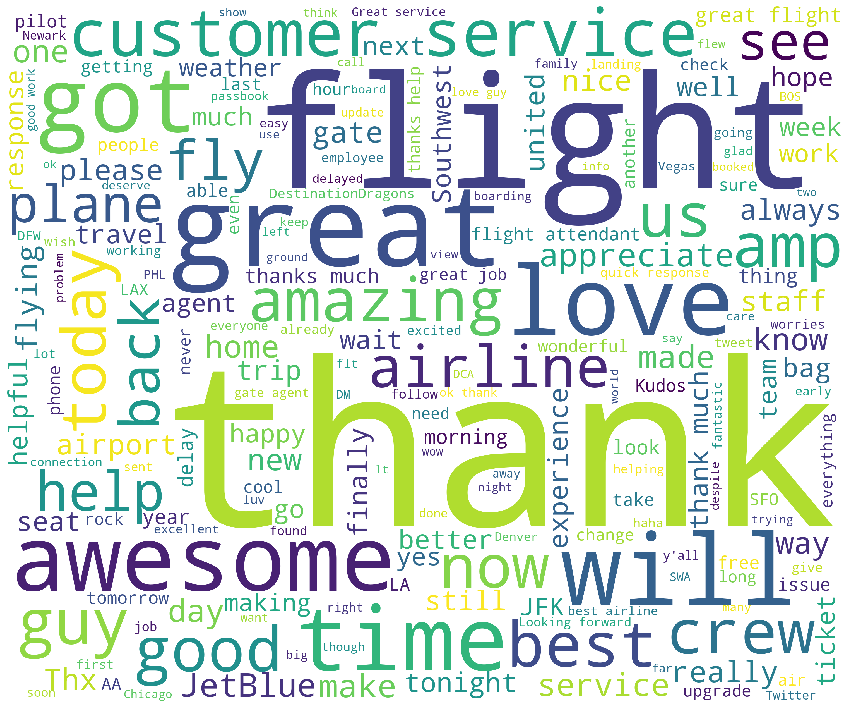

In [33]:
draw_wordcloud('positive')

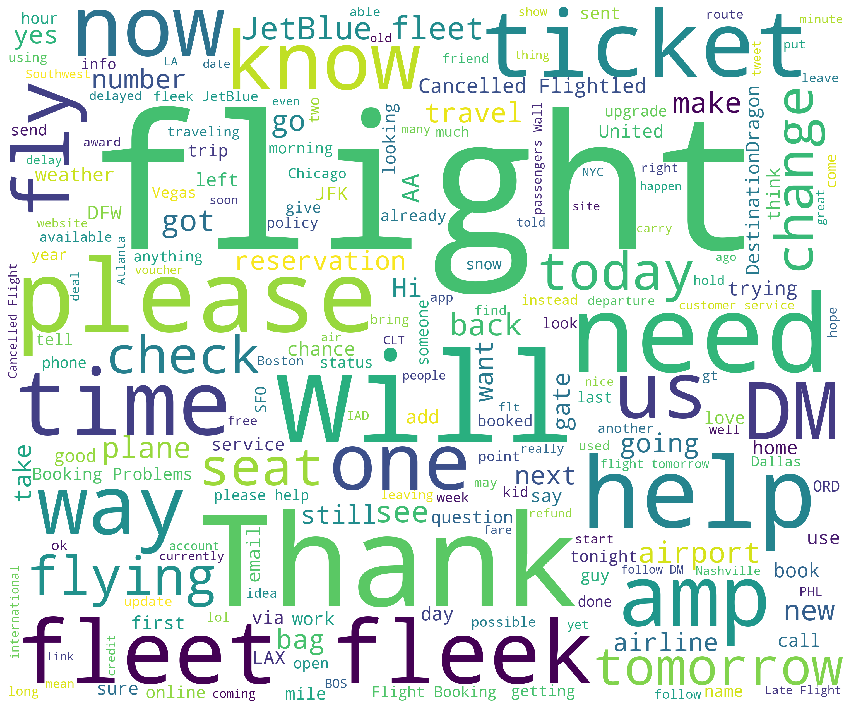

In [34]:
draw_wordcloud('neutral')

## 5) DATA MINING AND MACHINE LEARNING

### 5.1) Filter tweets function

The function **`filter_tweets`** allows the user to *tokenize* the tweet removing the *noise*:

**Tokens removed**:
*   Stop words
*   Punctuation
*   Tokens with less than 3 characters
*   Tokens containing a non alphabet character (i.e. "/", "@", etc.)

Then the trailing whitespaces are removed from the token using `strip()` and finally is converted to a lowercase word using `lower()`. If after removing the not desired tokens the `filtered_tweet` is empty, we do not include it into the `list_filtered_tweets`.

**Arguments**: 
*   `list_tweets`: array containing the tweets. 
*   `number_observations`: how many observations we want to treat (it will be removed in the future but now is usefull)

In [63]:
def filter_tweets(list_tweets, number_observations):  # TO DO: zip with account_name
    list_filtered_tweets = []

    for tweet in list_tweets[:number_observations]:
        filtered_tweet = []
        sentence = English()(tweet)

        for word in sentence:
            #if len(word) > 2 and not word.is_stop and word.is_alpha:
            if not word.is_stop:
                filtered_tweet.append(word.string.strip().lower())
        
        if len(filtered_tweet) != 0:
            list_filtered_tweets.append(filtered_tweet)
            
    return list_filtered_tweets

Here an example where the first 200 tweets from the dataframe `tweets` are filtered.

> Indented block



In [64]:
filter_tweets_sample = filter_tweets(list(tweets["text"]), 200)
for tweet_filtered in filter_tweets_sample:
  print(tweet_filtered)

['@virginamerica', '@dhepburn', 'said', '.']
['@virginamerica', 'plus', 'added', 'commercials', 'experience', '...', 'tacky', '.']
['@virginamerica', 'today', '...', 'mean', 'need', 'trip', '!']
['@virginamerica', 'aggressive', 'blast', 'obnoxious', '"', 'entertainment', '"', 'guests', "'", 'faces', '&', 'amp', ';', 'little', 'recourse']
['@virginamerica', 'big', 'bad', 'thing']
['@virginamerica', 'seriously', 'pay', '$', '30', 'flight', 'seats', 'playing', '.', '', 'bad', 'thing', 'flying', 'va']
['@virginamerica', 'yes', ',', 'nearly', 'time', 'fly', 'vx', '“', 'ear', 'worm', '”', 'wo', 'away', ':)']
['@virginamerica', 'missed', 'prime', 'opportunity', 'men', 'hats', 'parody', ',', '.', 'https://t.co/mwpg7grezp']
['@virginamerica', ',', "didn't", '…', '!', ':-d']
['@virginamerica', 'amazing', ',', 'arrived', 'hour', 'early', '.', 'good', '.']
['@virginamerica', 'know', 'suicide', 'second', 'leading', 'cause', 'death', 'teens', '10', '-', '24']
['@virginamerica', '&', 'lt;3', 'pretty'

In [62]:
#Adding filtered tweets to our dataset (here we only filtered out stop words)
table_200_lines = tweets[:200]
table_200_lines["filtered_tweets"] = filter_tweets_sample
print(table_200_lines)

               tweet_id airline_sentiment  airline_sentiment_confidence  \
0    570306133677760513           neutral                        1.0000   
1    570301130888122368          positive                        0.3486   
2    570301083672813571           neutral                        0.6837   
3    570301031407624196          negative                        1.0000   
4    570300817074462722          negative                        1.0000   
..                  ...               ...                           ...   
195  569282249717194754          negative                        1.0000   
196  569277854950817792          negative                        1.0000   
197  569277352129138688          negative                        0.7158   
198  569263837448269826          negative                        1.0000   
199  569262527281913857          positive                        1.0000   

              negativereason  negativereason_confidence         airline  \
0                       

/Users/Sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 5.2) Search group function

The function **`search_group_classes`** allows the user to classify tweets by passangers classes:

**Context**:
From a business perspective, the company needs to prioritize which customer needs to be replied to firstly. The idea, is to create several classes and then sort based on priority. In the ideal world, this priority will be based on ticket price but this information cannot be inferred.

- The first approach is to classify into 2 classes: **business class** and **not business class** only using the tweet text (i.e.: type of words in the tweet, orthography, etc.)

- The second approach is to figure out what is the scope of the tweet. For instance, if the account is verified, or the complaint is made by a very popular account (with a lot of followers) the complaint needs to be dealt quickly. *(NOT IMPLEMENTED)*

**Arguments**: 
*   `airline_sentiment`: determines the sentiment analysis we want to work with. Possible values: `('positive', 'negative', 'neutral')` 
*   `list_words`: words that define the group class, i.e.`("business class|first class|priority|preference")`

In [37]:
def search_group_classes(airline_sentiment, list_words):
    df_neg = (tweets[tweets['airline_sentiment'] == airline_sentiment])
    list_tweets = df_neg["text"]

    output = []
    for tweet in list_tweets:
        if re.findall(list_words, tweet):
            output.append(tweet)

    return output

Here we want to gathered the **business class tweets** from the dataset `tweets`.

In [38]:
business_class = ("business class|first class|priority|preference")
business_class_tweets = search_group_classes("negative", business_class)
for bc_tweet in business_class_tweets:
    print(bc_tweet)

@VirginAmerica I need to register a service dog for a first class ticket from SFO &gt; Dulles. The phone queue is an hour or longer. Pls advise
@united only thing confusing me is why I lost priority boarding? I'm a mileage plus card member 😔
@united three delayed flights and missed connections on first class flights and not get any compensation for losing those seats...
@united your first class is a joke, compared to all the others I have flown, don't ask for extra peanuts... That's NOT allowed! @AirCanada
@united - you rebooked me to UA1764 after UA 3883 was Cancelled Flightled. I paid for first class ticket - but new seat is 38E. Can you please fix!
@united we've been seating for 5hrs inside flight UA936 at #IAD delayed. We've only been offered water &amp; cookies in business class. #failed
@united can you make sure I’m on the upgrade list for 2/23 EWR-PDX using my GPU priority? Got a weird email about it.
@united hello I am flying first class and am behind 20 people on zone 1!!!!!  

### 5.3) Tweet sentiment analysis

The function **`tweet_sentiment_analysis`** computes the sentiment analysis of each tweet `polarity` and `subjectivity` and then sorts the bunch of tweets based on the polarity level of the tweet *(NOT IMPLEMENTED)*

> **Polarity** : Polarity is a float value within the range `[-1.0 to 1.0]` where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

> **Subjectivity**: Subjectivity is a float value within the range `[0.0 to 1.0]` where 0.0 is very objective and 1.0 is very subjective. 

In [41]:
def tweet_sentiment_analysis(filter_tweets_class):
    filter_tweets_string = []
    results = []
    sentiment_polarity = []
    sentiment_subjectivity = []

    # Converting the tokens list to a string
    for tweet in filter_tweets_class:
        filter_tweets_string.append(" ".join([word for word in tweet]))

    # Computing the sentiment analysis, applying method correct() to attempt spelling correction
    for tweet_filtered in filter_tweets_string:
        sentiment_polarity.append(TextBlob(tweet_filtered).correct().sentiment.polarity)
        sentiment_subjectivity.append(TextBlob(tweet_filtered).correct().sentiment.subjectivity)
        results.append(tweet_filtered)

    return list(zip(sentiment_polarity, sentiment_subjectivity, results))

In [66]:
def sentiment_analysis_with_text_blob(tweet_to_be_classified): #here we use unfiltered tweets because TextBlob filters them 
    list_sentiments = []

    for element in tweet_to_be_classified:
        list_sentiments.append(TextBlob(element).sentiment)
        
    return list_sentiments

Here an example for the first 100 tweets from our dataframe "tweets"

> 

In [80]:
list_sentiments = sentiment_analysis_with_text_blob(tweets["text"]) 

In [81]:
sentiment_table = pd.DataFrame(list_sentiments)
print(sentiment_table)

       polarity  subjectivity
0      0.000000      0.000000
1      0.000000      0.000000
2     -0.390625      0.687500
3      0.006250      0.350000
4     -0.350000      0.383333
...         ...           ...
14635  0.000000      0.600000
14636 -0.300000      0.600000
14637  0.000000      0.000000
14638 -0.125000      0.375000
14639  0.166667      0.166667

[14640 rows x 2 columns]


Now are are going to conver the sentiment data we found into strings.
Such that: 
* -1 <= polarity < 0  => the tweet is negative <br>
* polarity = 0        => the tweet is neutral <br>
* 0 < polarity <= 1   => the tweet is positive <br>

Subjectivity ϵ {0, 1}
* 0 < subjectivity <= 0.5   => the tweet is objective <br>
* 0.5 < subjectivity <= 1   => the tweet is subjective <br>

=> Note: This is a subjective choice and can be changed

In [83]:
list_polarity_as_string=[]
for element in sentiment_table["polarity"]:
    if -1 <= element < 0:
        list_polarity_as_string.append("negative")
    elif element == 0:
         list_polarity_as_string.append("neutral")
    else: 
        list_polarity_as_string.append("positive")

#Adding to tweets table
tweets["polarity_string"] = list_polarity_as_string
print(tweets)

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \

In [85]:
#Conversion
sentiment_equal = []
for element in zip(tweets["airline_sentiment"],tweets["polarity_string"]):
    if element[0]==element[1]:
        sentiment_equal.append(1)
    else:
        sentiment_equal.append(0)     


Here we are counting the number of sentiments that are the same than the ones provided by the dataset

In [90]:
number_equal_sentiment = 0
for element in zip(tweets["airline_sentiment"],tweets["polarity_string"]):
    if element[0]==element[1]:
        number_equal_sentiment += 1 
print("We estimated", number_equal_sentiment, "sentiments in the same way as the sentiments provided by the data set.")

We estimated 6798 sentiments in the same way as the sentiments provided by the data set.


In [110]:
#ratio = number_equal_sentiment/total nbr of tweets
ratio = number_equal_sentiment/(len(tweets))
print("The ratio of equal sentiments is of {:.2%}".format(ratio))

The ratio of equal sentiments is of 46.43%


In [40]:
filter_tweets_bc = filter_tweets(business_class_tweets, len(business_class_tweets))
"""for tweet_filtered in filter_tweets_bc:
      print(tweet_filtered)"""

sentiment_analysis_class = tweet_sentiment_analysis(filter_tweets_bc)
for tweet in sentiment_analysis_class:
        print(tweet)

# TO DO: sort the tweets based on polarity and add account_name

(0.0, 0.0, 'need register service dog class ticket sfo dulles phone queue hour longer pls advise')
(-0.3, 0.4, 'thing confusing lost priority boarding mileage plus card member')
(0.0, 0.0, 'delayed flights missed connections class flights compensation losing seats')
(0.0, 0.1, 'class joke compared flown ask extra peanuts allowed')
(0.13636363636363635, 0.45454545454545453, 'rebooked cancelled flightled paid class ticket new seat fix')
(-0.5, 0.3, 'seating inside flight iad delayed offered water amp cookies business class failed')
(0.0, 0.9444444444444444, 'sure upgrade list ewr pdx gpu priority got weird email')
(0.0, 0.0, 'hello flying class people zone pls pass app dept board class')
(-0.3, 0.6, 'nope called lost seating preference paid sit happens flight late flightr')
(0.0, 0.0, 'booked class curbside delivery hours counting teamusa')
(0.0, 0.0, 'class passenger pay inflight wifi')
(0.0, 0.0, 'try upgrade seats class wait time phone minutes help')
(-0.55, 1.0, 'sorry cold chicago m

*TO DO: implement N-gramms*